<a href="https://colab.research.google.com/github/yfwang09/ShElastic/blob/master/examples/Case05-Hydrogel_Cell_Interaction_with_Penalty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hydrogel-Cell Interaction Test Case

In this case, we load the deformed shape of the spherical hydrogel as shown in the next few cells.

In [1]:
# If you run this notebook from colab, run this cell first
import os
codepath = '/content/ShElastic'
if not os.path.exists(codepath):
    !git clone https://github.com/yfwang09/ShElastic.git 
    !pip install pyshtools
os.chdir(os.path.join(codepath, 'examples'))

Cloning into 'ShElastic'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 1157 (delta 35), reused 18 (delta 9), pack-reused 1081
Receiving objects: 100% (1157/1157), 147.52 MiB | 30.40 MiB/s, done.
Resolving deltas: 100% (421/421), done.
     |████████████████████████████████| 10.8MB 178kB/s 


In [2]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.sparse.linalg import lsqr, spsolve
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os.path
from itertools import permutations
import pyshtools

sys.path.append('..')
from shelastic.shutil import SphCoord_to_CartCoord, CartCoord_to_SphCoord, GLQCartCoord
from shelastic.shutil import SHCilmToVector, SHVectorToCilm, SHVec2mesh, SHmesh2Vec
from shelastic.shutil import TransMat, l_coeffs, m_coeffs, LM_list, lmk2K, K2lmk
from shelastic.shbv import generate_submat, Uvec2Tvec, Tvec2Uvec
from shelastic.shvis  import plotfv, vismesh, visSHVec, visSH3d
from shelastic.sphere_utils import loadCoeffs, arbitrary_force, Ur_interp
from shelastic.sphere_utils import usurf2umesh, dumesh_dus, usurf2vec
from shelastic.sphere_utils import Tvec2Tres, usurf2dr2, calculateTfv, genSmat, genLmat, grad_usurf2dr2

## Input information

In [3]:
############################# change inputs here #################################
# Data file name
datadir = '../testdata'
smoothed = 'smoothed_3'
dilated = '_1um_dilated'
#dilated = '_softedge'
shapename = 'Shape2'
datafile = os.path.join(datadir, shapename+'_Coordinates_Cart_'+smoothed+'.csv')
connfile = os.path.join(datadir, shapename+'_Connectivity.csv')
maskfile = os.path.join(datadir, shapename+'_Mask'+dilated+'.csv')
print('Cartesian coordinates: %s'%datafile)
print('Node connectivity: %s'%connfile)
print('Traction-free mask: %s'%maskfile)

# Material properties
mu0 = 300/3; nu0 = 0.499;

# Spherical Harmonics Analysis Settings
lJmax = 20; lKmax = lJmax; lmax_plot = 60;

# initial guess settings
init_guess_type = 'ur-only' #'ur-only' or 'true'

# regularizations
mybeta  = 1     # traction residual magnitude (alpha in the paper)
mygamma = 1     # anti-aliasing parameter     (beta  in the paper)

# program switches
plot_figure = True # False
myord = 1; # myord: p-norm order (1-mean value)

# minimization settings
N_period = 2000
maxiter_per_period = 5
CG_gtol = 1e-5
eps = 1e-5               # for jacobian

minimizer = 'CG'
minimizer_config = {'maxiter': maxiter_per_period, 'disp': True, 'gtol': CG_gtol}

# dump files for minimization
savename = shapename+('_b%.0e'%(mybeta))+('_lmax%d'%lJmax)+smoothed+dilated+'_g%.0e'%mygamma

# settings for loading \hat{U}, \hat{T} coefficients
Cmat, Dmat = loadCoeffs(mu0, nu0, lJmax, 'reg')

Cartesian coordinates: ../testdata/Shape2_Coordinates_Cart_smoothed_3.csv
Node connectivity: ../testdata/Shape2_Connectivity.csv
Traction-free mask: ../testdata/Shape2_Mask_1um_dilated.csv
Integrating modes to a matrix
1323 1323
Integrating modes to a matrix
1323 1323


## Load the geometry

Visualize the traction-free boundary

data, connectivity: (8136, 3) (16268, 3)
id of nodes, edges, facets: (8136,) (24402, 2) (16268, 3)
coord of nodes, edges, facets: (8136, 3) (24402, 2, 3) (16268, 3, 3)


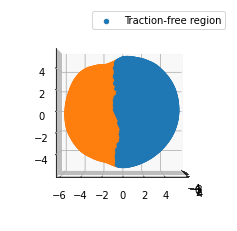

In [4]:
#### load the geometry ####
# Vs, Vp: list of nodes (nV, trivial), coordinates of the nodes (nVx3)
# Es, Ep: list of edges (nEx2), list of points on the edges (nEx2x3)
# Fs, Fp: list of facets (nFx3), list of points on the facets (nFx3x3)
# Tfv: traction free boundary map of the node list
# Tfe: traction free boundary map of the edge list
# Tff: traction free boundary map of the face list
# Tf_diluted: diluted traction free boundary map

data = np.genfromtxt(datafile, delimiter=',')
conn = np.genfromtxt(connfile, delimiter=',', dtype=np.int)
if dilated == '_softedge':
    masktype = np.float
else:
    masktype = np.int
if shapename == 'Shape4':
    mask = np.zeros_like(data[:,0]).astype(masktype)
else:
    mask = np.genfromtxt(maskfile, dtype=masktype)
print('data, connectivity:', data.shape, conn.shape)

Fs = conn - 1
Np = data.shape[0]
Vs = np.arange(Np)
edge_conn = spm.lil_matrix((Np, Np), dtype=bool)
for i, j in permutations(range(3), 2):
    edge_conn[Fs[:, i], Fs[:, j]] = True
Es = spm.triu(edge_conn).tocoo()
Es = np.vstack([Es.row, Es.col]).T
print('id of nodes, edges, facets:', Vs.shape, Es.shape, Fs.shape)
Vp = data[..., :3]
Ep = Vp[Es, :]; Fp = Vp[Fs, :];
print('coord of nodes, edges, facets:', Vp.shape, Ep.shape, Fp.shape)

if dilated == '_softedge':
    Tfv = (mask > 0.5)
else:
    Tfv = mask.astype(np.bool)

#### Plot the geometry (Vp) ####
if plot_figure:
    fig = plt.figure(figsize=plt.figaspect(1))
    ax = fig.add_subplot(111, projection='3d')

    nTfv = np.logical_not(Tfv)
    ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], label='Traction-free region')
    ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2])
    ax.legend()

    ax.view_init(azim=0, elev=0)
    plt.show()

Then we determine the original radius of the particle, assuming the particle is incompressible. The total volume can be estimated by adding the volume of the tetrahedrons. The volume of a tetrahedron is calculated as:

$$
V_{0123}=\frac{1}{6}
\begin{vmatrix}
 x_1 & y_1 & z_1 & 1\\ 
 x_2 & y_2 & z_2 & 1\\ 
 x_3 & y_3 & z_3 & 1\\ 
 0 & 0 & 0 & 1\\ 
\end{vmatrix}
$$

In [5]:
tet = np.zeros((Fs.shape[0], 4, 4))
tet[:,:-1,:-1] = Fp
tet[:,:,-1] = 1
vol = np.sum(np.linalg.det(tet)/6, axis=0)
r0 = np.cbrt(vol/(4/3*np.pi))
print('V = %.4f, r0 = %.4f'%(vol, r0))

V = 607.1011, r0 = 5.2528


We need to solve the reverse problem of a deformed shape. We will try the following methods to tackle this problem:

1. Assume $r$-direction deformation only, using the solution as initial guess to the optimization
2. LSQ solving coeffs of the SH solutions for fitting both the traction-free boundary and the shape

Conversion between complex and real spherical harmonics, for $m>0$

$$
f_{lm} = \left[f_l^m+(-1)^mf_l^{-m}\right]/\sqrt{2}\\
f_{l-m}=i\left[f_l^m-(-1)^mf_l^{-m}\right]/\sqrt{2}\\
f_l^m = (f_{lm}-if_{l-m})/\sqrt{2}\\
f_l^{-m} = (-1)^m(f_{lm}+if_{l-m})/\sqrt{2}
$$

for $m=0$:

$$
f_{l0} = f_l^0
$$


## 2. LSQ solving SH coeffs for displacement field

Obviously, the decomposition is not satisfactory. It is not reasonable to assume the deformation is only on $r$-direction. In this section, we will try to optimize SH coeffs, so that the deformed shape is closest to the data. Notice that the integral of a spherical harmonic function on the sphere surface is:

$$
\int_0^{2\pi}\!\int_0^{\pi}Y_l^m(\theta,\varphi)\sin\theta d\theta d\varphi = 4\pi\delta_{l0}\delta_{m0}
$$

Therefore, only the $Y_0^0$ term controls the rigid body translation (constant). If we only impose higher mode spherical harmonics, there will be no rigid body motion.

### Develop the interpolation function for $u_r(\theta,\varphi)$ from data

shape fitting accuracy: 0.00106003023844973


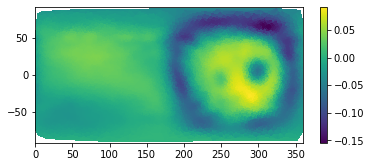

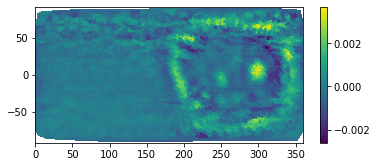

In [6]:
f_interp = Ur_interp(Vp/r0, lmax=lJmax+20, plot_figure=plot_figure)
# Define shape reference
latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lJmax, extend=True)
lon0, lat0 = np.meshgrid(lonsdeg, latsdeg)
X0surf = np.stack([lat0, lon0], axis=-1)
X0 = GLQCartCoord(lJmax)

### Define the initial guess

Shape2_b1e+00_lmax20smoothed_3_1um_dilated_g1e+00
['AK_Shape2_b1e+00_lmax20smoothed_3_1um_dilated_g1e+00_00.npz']
Integrating modes to a matrix
1323 1323
Integrating modes to a matrix
1323 1323


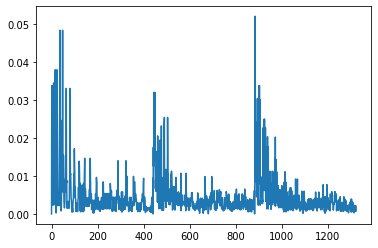

Displacement in Spherical Coordinates...


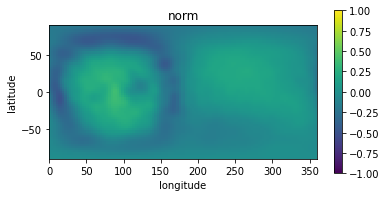

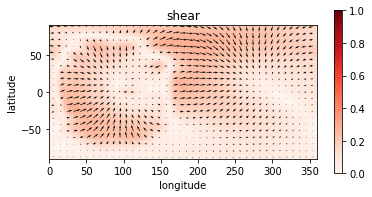

Traction in Spherical Coordinates...


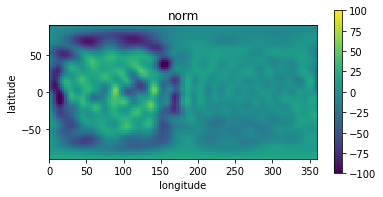

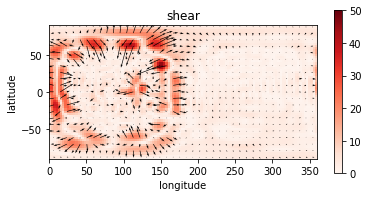

In [15]:
import glob
filelist = glob.glob('AK_'+savename+'_??.npz')
print(savename)
print(filelist)
nfile = len(filelist)
if nfile > 0:
    u0_surf = np.load('AK_'+savename+'_%02d.npz'%(nfile-1))['u_surf_list'][-1, ...]
    if u0_surf.size < np.prod(X0surf.shape):
        if len(u0_surf.shape) != 3:
            u0_surf = u0_surf.reshape(lJmax+1, 2*lJmax+1, 2)
        new_u0_surf = np.zeros_like(X0surf)
        new_u0_surf[:, :-1, :] = u0_surf
        new_u0_surf[:, -1,  :] = u0_surf[:, 0, :]
        u0_surf = new_u0_surf
elif init_guess_type == 'ur-only':
    u0_surf = np.zeros_like(X0surf)

U0vec, aK, T0vec = usurf2vec(u0_surf, f_interp, lJmax)
if plot_figure:
    fig, ax = plt.subplots()
    ax.plot(np.abs(T0vec))
    plt.show()
    print('Displacement in Spherical Coordinates...')
    fig, ax = visSHVec(U0vec*r0, lmax_plot=lmax_plot, SphCoord=True, Complex=True,
                       n_vrange=(-1, 1), s_vrange=(0, 1),
                       config_quiver=(2, 3, 'k', 10), lonshift=180, figsize=(6,3))
    print('Traction in Spherical Coordinates...')
    fig, ax = visSHVec((T0vec)*mu0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, 
                       n_vrange=(-100, 100), s_vrange=(0, 50),
                       config_quiver=(2, 3, 'k', 500), lonshift=180, figsize=(6,3))

### Define the traction free region based on the initial guess

In [16]:
# Define weights and traction free region
if dilated == '_softedge':
    isTfv = calculateTfv(U0vec, lJmax, Vp/r0, mask, lat_weight=True)
else:
    isTfv = calculateTfv(U0vec, lJmax, Vp/r0, Tfv, lat_weight=True)
print(isTfv.shape)

(21, 42)


## Coordinate transformation

The degree of freedom is defined as surface-shift $(\theta,\varphi)_i$, where $i=1\dots N, N = (l_{\max}+1)(2l_{\max}+1)$. Transformation from the surface-shift representation to displacement in Cartesian coordinates is written as:

$$
r_i = r_i(\theta_i, \varphi_i) \\
\vec{x}_i = \mathbf{Q}\cdot[r,\theta,\varphi]\\
\vec{u}_i = \vec{x}_i - \vec{X}_i
$$

We use the 3-point formulation to obtain the numerical difference:

$$
f'(x_i)\approx\frac{f(x_{i-1})+f(x_{i+1})-2f(x_{i})}{h}
$$

where $x_{i+1}-x_i=x_i-x_{i-1}=h$

### Linear transformation

The linear relation between `umesh`, `Uvec`, `Tvec`, and `Tmesh` can be written as:

$$
U_{mesh} = \sum \hat{U}_{lmk}Y_l^m\hat{\mathbf{e}}_k \\
\hat{U}_{lmk} = \mathbf{D}\cdot A_K = \mathbf{S}U_{mesh}\\
\hat{T}_{lmk} = \mathbf{C}\cdot A_K = \mathbf{C}\mathbf{D}^{-1}\mathbf{S}U_{mesh} \\
T_{mesh} = \sum \hat{T}_{lmk}Y_l^m\hat{\mathbf{e}}_k
$$

Thus it can be simplified as:

$$
T_{mesh} = \mathbf{L}U_{mesh}
$$

where $\mathbf{S}\in\mathbb{C}^{3M}\times\mathbb{C}^{3N}, \mathbf{L}\in\mathbb{R}^{3N}\times\mathbb{R}^{3N}, M=(l_{\max}+1)^2,N=(l_{\max}+1)(2l_{\max}+1)$ is the number of grid nodes on the sphere surface by GLQ meshing.

Note that $\mathbf{L}$ is positive semidefinite, which does *NOT* satisfy $L=L^T$

$\mathbf{S}$ and $\mathbf{L}$ can be obtained by operating the algorithm on each column of an *identity matrix* $I$, since they are linear operations.

## Jacobian of the target function

The target function is written as:
$$
f(\vec{u}_s)=T_{res}+\beta E_{el}+\gamma E_{pen}=
{1\over N}\vec{T}_{mesh}^T\mathbf{P}\vec{T}_{mesh}+2\pi\beta\vec{U}^{(K)}\cdot\vec{T}^{(K)} + |\mathbf{Q}\vec{T}^{(K)}|^2
$$

where the surface shift $[\vec{u}_s]_i=(\theta,\varphi)_i$. Thus the Jacobian for residual traction and elastic energy can be written separately as:

$$
{\partial E_{el}\over\partial U_{mesh}}=
2\pi\left(\mathbf{S}^T\mathbf{CD^{-1}S}+\mathbf{S^TD^{-T}C}^T\mathbf{S}\right)\vec{U}_{mesh}
$$

$$
{\partial T_{res}\over\partial U_{mesh}}={2\over N}\mathbf{L}^T\mathbf{P}\mathbf{L}\vec{U}_{mesh}
$$

$$
{\partial E_{pen}\over\partial U_{mesh}}=
(\mathbf{QCD^{-1}S})^H\mathbf{QCD^{-1}S}U_{mesh}
$$

$$
\frac{\partial f}{\partial\vec{u}_s}=
\left[{2\over N}\mathbf{L}^T\mathbf{P}\mathbf{L}+2\pi\beta\left(\mathbf{S}^T\mathbf{CD^{-1}S}+\mathbf{S^TD^{-T}C}^T\mathbf{S}\right)\right]\vec{U}_{mesh}\frac{\partial\vec{U}_{mesh}}{\partial\vec{u}_s}
$$

where diagonal matrix $\mathbf{P}$ is the matrix that selects the traction vector on the traction-free surface, and diagonal matrix $\mathbf{Q}$ is the anti-aliasing damping coefficients for high-order traction modes.

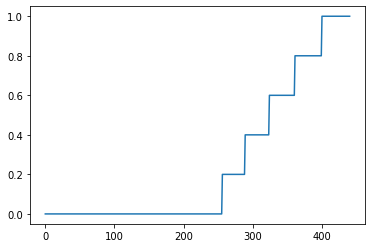

In [17]:
lmax = lJmax
ldamp_hi = lmax; ldamp_lo = lmax - 5;
lv, _ = LM_list(lmax); lv_ones = np.ones_like(lv);
lv_lim = np.minimum(np.maximum(lv, ldamp_lo), ldamp_hi)
ldamp = (np.maximum(lv_lim-ldamp_lo, 0) / (ldamp_hi - ldamp_lo))**1
Q = spm.csr_matrix(np.diag(np.tile(ldamp, 3)).astype(np.complex))
# print(Q.shape, CDmat.shape)
plt.plot(ldamp)
plt.show()

In [18]:
# Calculating L, S, P matrices for Jacobian evaluation
if not os.path.exists('JacMats.npz'):
    tic = time.time()
    Lmat = genLmat(lJmax, Cmat=Cmat, Dmat=Dmat)
    print('Time for generating L matrix: %.2fs'%(time.time() - tic))
    tic = time.time()
    Smat = genSmat(lJmax, Cmat=Cmat, Dmat=Dmat)
    print('Time for generating S matrix: %.2fs'%(time.time() - tic))
    Dinv = spm.linalg.inv(Dmat)
    CDmat = Cmat.dot(Dinv)
    tic = time.time()
    CDSmat = np.asmatrix(CDmat.dot(Smat))
    SHCDS = np.asmatrix(Smat).H.dot(CDSmat)
    print('Time for generating S^HCD^{-1}S matrix: %.2fs'%(time.time() - tic))
    np.savez_compressed('JacMats.npz', Lmat=Lmat, Smat=Smat, CDSmat=CDSmat, SHCDS=SHCDS)
else:
    loadnpz = np.load('JacMats.npz')
    Lmat = np.asmatrix(loadnpz['Lmat'])
    Smat = np.asmatrix(loadnpz['Smat'])
    CDSmat= np.asmatrix(loadnpz['CDSmat'])
    SHCDS = np.asmatrix(loadnpz['SHCDS'])
tic = time.time()
QCDSmat = Q.dot(CDSmat)
QCDSHQCDS = QCDSmat.H.dot(QCDSmat).real
print('Time for generating QCDSHQCDS matrix: %.2fs'%(time.time() - tic))
tic = time.time()
P = np.diag(np.stack([isTfv]*3, axis=-1).flatten())
TresJac = 2*np.asmatrix(np.dot(np.dot(Lmat.T, P), Lmat))/(lJmax+1)/(lJmax*2+1) 
EelJac  = 2*np.pi*(SHCDS+SHCDS.H)
penJac  = QCDSHQCDS+QCDSHQCDS.H
print('time of matrix build:', time.time() - tic)

Time for generating L matrix: 22.82s
Time for generating S matrix: 2.52s
Time for generating S^HCD^{-1}S matrix: 4.84s
Time for generating QCDSHQCDS matrix: 2.29s
time of matrix build: 2.639357089996338


The cost function value of the initial guess is:

In [19]:
T0dist = Tvec2Tres(T0vec, lJmax, isTfv=isTfv, norm_order=myord)
E0el = np.vdot(U0vec, T0vec).real*2*np.pi
pen0 = np.vdot(Q.dot(T0vec), Q.dot(T0vec)).real
print('Traction residual: %.4e Pa'%(np.sqrt(T0dist)*mu0))
print('Elastic energy: %.4e pJ'%(E0el*(r0/1e6)**3*mu0*1e12))
print('funval: %.4e %.4e %.4e'%(T0dist, E0el, pen0))

Traction residual: 5.9846e+00 Pa
Elastic energy: 6.7442e-04 pJ
funval: 3.5816e-03 4.6532e-02 2.3742e-03


In [20]:
target_args = (f_interp, lJmax, mybeta, myord, X0surf, X0, isTfv, Cmat, Dmat, 
               mu0, nu0, np.array([1]), np.array([1]), eps, '2-point', (TresJac, EelJac, penJac), mygamma)

def print_iter(xk):
    Uvec, aK, Tvec = usurf2vec(xk, f_interp, lJmax, X0surf=X0surf, X0=X0, Cmat=Cmat, Dmat=Dmat)
    Tdist = Tvec2Tres(Tvec, lJmax, isTfv=isTfv, norm_order=myord)
    Eel = np.vdot(Uvec, Tvec).real*2*np.pi
    pen = np.vdot(Q.dot(Tvec), Q.dot(Tvec)).real
    dr  = usurf2dr2(xk, *target_args)
    print('%13.4ePa%13.4epJ%13.4e%13.4e%13.4e%13.4e'%(np.sqrt(Tdist)*mu0, Eel*(r0/1e6)**3*mu0*1e12, Tdist, Eel, pen, dr))

u_surf = u0_surf.flatten().copy()
u_surf_list = [u_surf, ]
tic_start = time.time()
for i in range(N_period):
    print('Period %4d  Tr'%i, ' '*10, 'Eel', ' '*9, 'f0',' '*9, 'f1', ' '*9, 'f2', ' '*9, 'f')
    tic = time.time()
    u_res = minimize(usurf2dr2, u_surf.flatten(), args=target_args, jac=grad_usurf2dr2,
                     method = minimizer, options=minimizer_config, callback=print_iter)
    print('Iteration Time: %.2fs'%(time.time() - tic))
    u_surf = u_res.x.copy()
    u_surf_list.append(u_surf)
    if u_res.success:
        break
    if i%10 == 9:
        print('update isTfv at step %d'%i)
        Uvec, aK, Tvec = usurf2vec(u_surf, f_interp, lJmax, X0surf=X0surf, X0=X0, Cmat=Cmat, Dmat=Dmat)
        if dilated == '_softedge':
            isTfv = calculateTfv(Uvec, lJmax, Vp/r0, mask, lat_weight=True)
        else:
            isTfv = calculateTfv(Uvec, lJmax, Vp/r0, Tfv, lat_weight=True)
        P = np.diag(np.stack([isTfv]*3, axis=-1).flatten())
        TresJac = 2*np.asmatrix(np.dot(np.dot(Lmat.T, P), Lmat))/(lJmax+1)/(lJmax*2+1)
        target_args = (f_interp, lJmax, mybeta, myord, X0surf, X0, isTfv, Cmat, Dmat, 
               mu0, nu0, np.array([1]), np.array([1]), eps, '2-point', (TresJac, EelJac, penJac), mygamma)
print('Total Wall Time: %.2fs'%(time.time() - tic_start))

Period    0  Tr            Eel           f0           f1           f2           f
   6.0834e+00Pa   6.7573e-04pJ   3.7007e-03   4.6623e-02   1.5909e-03   5.1915e-02
   6.0919e+00Pa   6.7565e-04pJ   3.7111e-03   4.6618e-02   1.5526e-03   5.1881e-02
   6.0549e+00Pa   6.7613e-04pJ   3.6661e-03   4.6651e-02   1.4374e-03   5.1754e-02
   6.0557e+00Pa   6.7619e-04pJ   3.6672e-03   4.6655e-02   1.3987e-03   5.1721e-02
   6.0566e+00Pa   6.7696e-04pJ   3.6682e-03   4.6708e-02   1.3163e-03   5.1693e-02
         Current function value: 0.051693
         Iterations: 5
         Function evaluations: 25
         Gradient evaluations: 25
Iteration Time: 5.30s
Period    1  Tr            Eel           f0           f1           f2           f
   6.0520e+00Pa   6.7700e-04pJ   3.6627e-03   4.6711e-02   1.2646e-03   5.1638e-02
   6.0565e+00Pa   6.7692e-04pJ   3.6681e-03   4.6705e-02   1.2595e-03   5.1633e-02
   6.0558e+00Pa   6.7691e-04pJ   3.6672e-03   4.6704e-02   1.2378e-03   5.1609e-02
   6.0480e+00Pa  

     fun: 0.05095432255593217
     jac: array([-4.75970982e-08, -1.69121934e-08, -2.27608340e-07, ...,
        4.59747335e-08,  0.00000000e+00,  0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 1
    njev: 5
  status: 0
 success: True
       x: array([ 0.02312272,  2.32382192,  1.19140559, ...,  0.72168249,
       -8.07323475,  0.73356946])
Traction residual: 5.9324e+00 Pa
Elastic energy: 6.7805e-04 pJ
funval: 3.5193e-03 4.6783e-02


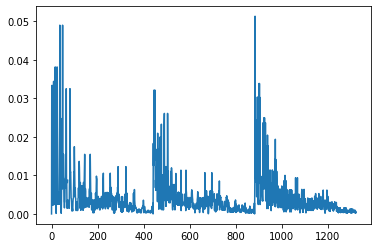

Displacement in Spherical Coordinates...


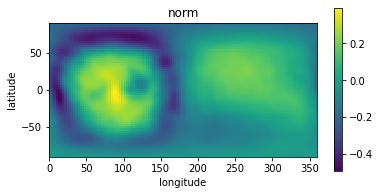

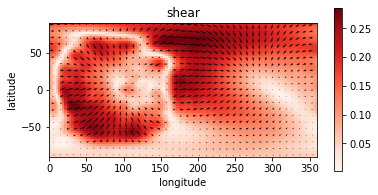

Traction in Spherical Coordinates...


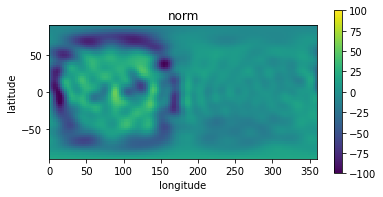

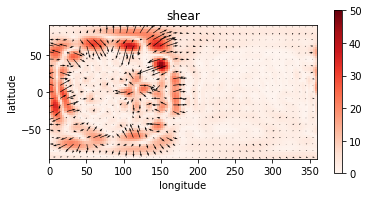

In [21]:
print(u_res)
u_surf = u_res.x

Usurfvec, aK, Tsurfvec = usurf2vec(u_surf, f_interp, lJmax, X0surf=X0surf, X0=X0, Cmat=Cmat, Dmat=Dmat)
Tsurfdist = Tvec2Tres(Tsurfvec, lJmax, isTfv=isTfv, norm_order=myord)
Eelsurf = np.vdot(Usurfvec, Tsurfvec).real*2*np.pi
print('Traction residual: %.4e Pa'%(np.sqrt(Tsurfdist)*mu0))
print('Elastic energy: %.4e pJ'%(Eelsurf*(r0/1e6)**3*mu0*1e12))
print('funval: %.4e %.4e'%(Tsurfdist, Eelsurf))

if plot_figure:
    fig, ax = plt.subplots()
    # ax.plot(np.abs(T_usr_vec))
    ax.plot(np.abs(Tsurfvec))
    plt.show()

    print('Displacement in Spherical Coordinates...')
    fig, ax = visSHVec(Usurfvec*r0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, #s_vrange=(0,0.01),
                       config_quiver=(2, 3, 'k', 10), lonshift=180, figsize=(6,3))
    print('Traction in Spherical Coordinates...')
    fig, ax = visSHVec((Tsurfvec)*mu0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, 
                       n_vrange=(-100, 100), s_vrange=(0, 50),
                       config_quiver=(2, 3, 'k', 500), lonshift=180, figsize=(6,3))

Visualize the shape in 3D...


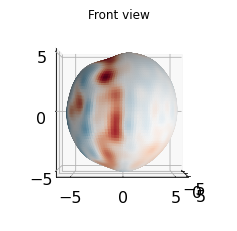

In [22]:
# %matplotlib notebook
if plot_figure:
    # umesh_fine_scaled = SHVec2mesh(U0vec, lmax=lmax_plot, SphCoord=False, Complex=True)
    # tmesh_fine = SHVec2mesh(T0vec*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)
    umesh_fine_scaled = SHVec2mesh(Usurfvec, lmax=lmax_plot, SphCoord=False, Complex=True)
    tmesh_fine = SHVec2mesh(Tsurfvec*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)
    print('Visualize the shape in 3D...')
    fig, ax = visSH3d(umesh_fine_scaled, cmesh=tmesh_fine, 
                      r0=r0, show=False, vmin=-100, vmax=100,
                      elevation=0, azimuth=0, 
                      surface=True, figsize=plt.figaspect(1))

    # reference data
    nTfv = np.logical_not(Tfv)
    #ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
    #ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
    ax.set_title('Front view')
    plt.show()

Evaluate Displacement and Traction in Cartesian Coordinates for plotting 3d shape...
Visualize the nodes in 3D...


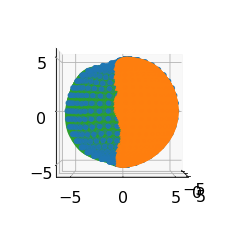

In [24]:
print('Evaluate Displacement and Traction in Cartesian Coordinates for plotting 3d shape...')
umesh1 = SHVec2mesh(U0vec, lmax=lJmax, SphCoord=False, Complex=True)
tmesh1 = SHVec2mesh(T0vec*mu0, lmax=lJmax, SphCoord=False, Complex=True)
umesh1_fine = SHVec2mesh(U0vec, lmax=lmax_plot, SphCoord=False, Complex=True)
tmesh1_fine = SHVec2mesh(T0vec*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)
tmesh1_sph_fine = SHVec2mesh(T0vec*mu0, lmax=lmax_plot, SphCoord=True, Complex=True)

print('Visualize the nodes in 3D...')
fig, ax = visSH3d(umesh1, cmesh=tmesh1, r0=r0, show=False, elevation=0, azimuth=0, surface=False, figsize=plt.figaspect(1))
nTfv = np.logical_not(Tfv)
ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
plt.show()

In [25]:
import glob
filelist = glob.glob('AK_'+savename+'_??.npz')
nfile = len(filelist)
np.savez('AK_'+savename+'_%02d.npz'%(nfile), 
         AK_iter=aK, u_surf_list=np.stack(u_surf_list, axis=0), 
         beta=mybeta, N=N_period)